# Overview

**GENERAL THOUGHTS:**
- How to handle SKUs with mulitple components? Does it make more sense to combine them into a single row? -> might want to try this as a next step


**DATA PREPROCESSING:**  
Imbalanced data:
- over_sampling for imbalanced data.
- cost-sensitive learning for imbalanced data.

continuous data:
- Impute missing data: SimpleImputer(strategy='median').
- Standardize data: StandardScaler().

categorical data:
- Impute missing data: SimpleImputer(strategy='most_frequent').
- Ordinal & Nominal data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).
- Unknown values ecoding and reordering of ordinal encoding: custom encoder "OrdinalEncoderExtensionUnknowns()".

target data:
- target encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)


**MULTI-CLASS CLASSIFIER:**
- Overview models to be considered:  
  - Baseline model: DummyClassifier(strategy="most_frequent")

**FINAL MODEL PERFORMANCE:**  
- Evaluation of the baseline model based on:
  - check model learning using cross validation with 5 folds.
  - evaluation performance on test data based on classification report
- Tracking of the best model with MLFlow for performance benchmarking with other approaches (Baseline, PyCaret, AutoGluon, PyTorch, ...) within the Repository.

In [ ]:
import datetime
import os
import sys

import yaml

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    PowerTransformer,
)

# ignore warnings
import warnings

warnings.filterwarnings("ignore")

with open("../env_vars.yml", "r") as file:
    config = yaml.safe_load(file)

# custom imports
sys.path.append(config["project_directory"])
from src import utils

In [ ]:
# General settings within the data science workflow

SEED = 42  # Ensure same data split as in other notebooks

# Load data and prepare data

In [ ]:
# load data
df = pd.read_csv(f"{config['data_directory']}/output/df_ml.csv", sep="\t")

# prepare data
df["material_number"] = df["material_number"].astype("object")
df_sub = df[
    [
        "material_number",
        "brand",
        "product_area",
        "core_segment",
        "component",
        "manufactoring_location",
        "characteristic_value",
        "material_weight",
        "packaging_code",
        "packaging_category",
    ]
]
df_sub = df_sub.dropna()

In [7]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75913 entries, 0 to 82976
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         75913 non-null  object 
 1   brand                   75913 non-null  object 
 2   product_area            75913 non-null  object 
 3   core_segment            75913 non-null  object 
 4   component               75913 non-null  object 
 5   manufactoring_location  75913 non-null  object 
 6   characteristic_value    75913 non-null  object 
 7   material_weight         75913 non-null  float64
 8   packaging_code          75913 non-null  object 
 9   packaging_category      75913 non-null  object 
dtypes: float64(1), object(9)
memory usage: 6.4+ MB


In [8]:
df_sub.head()

,material_number,brand,product_area,core_segment,component,manufactoring_location,characteristic_value,material_weight,packaging_code,packaging_category
0,75116293,BOT,PA5,Metal Grinding,6035765C21,Distribution Center,CORRUGATED,85.00,PCode_304109,Countertop display
1,75116293,BOT,PA5,Metal Grinding,6035940565,Distribution Center,WOOD FREE,0.54,PCode_440854,Countertop display
2,75116293,BOT,PA5,Metal Grinding,6035822768,Distribution Center,MCB/GT2,22.90,PCode_834649,Countertop display
3,75116293,BOT,PA5,Metal Grinding,6035822768,Distribution Center,MCB/GT2,22.90,PCode_834649,Countertop display
4,75116293,BOT,PA5,Metal Grinding,6035765P54,Distribution Center,CORRUGATED,85.00,PCode_304109,Countertop display


# Prep data for machine learning

## Split data into train/test

In [ ]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

print("Unique categories in y_train: ", y_train.nunique())
print("Unique categories in y_test: ", y_test.nunique())

Unique categories in y_train:  29
Unique categories in y_test:  29


# Build baseline model

In [ ]:
# train outside pipeline
baseline_strati = DummyClassifier(strategy="most_frequent", random_state=42)
baseline_strati.fit(X=X_train, y=y_train)
y_pred_train_baseline_strati = baseline_strati.predict(X=X_train)

# Predict and calculate f1_macro score for both train and test sets
y_pred_train = baseline_strati.predict(X_train)
y_pred_test = baseline_strati.predict(X_test)
train_f1_macro = f1_score(y_train, y_pred_train, average="macro")
test_f1_macro = f1_score(y_test, y_pred_test, average="macro")
print("Train score (f1_macro): ", train_f1_macro)
print("Test score (f1_macro): ", test_f1_macro)

Train score (f1_macro):  0.00987366292989466
Test score (f1_macro):  0.009872974645526479


# Baseline pipeline

## Pre-processing pipeline

In [ ]:
# DEFINE & EXECUTE PIPELINE
# define feature processing pipeline
numerical_features = X_train.select_dtypes(include="number").columns.tolist()
numeric_feature_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("log_transform", PowerTransformer()),
        # ('scale', MinMaxScaler())
    ]
)
categorical_features = X_train.select_dtypes(exclude="number").columns.tolist()
categorical_feature_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ]
)
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("number", numeric_feature_pipeline, numerical_features),
        ("category", categorical_feature_pipeline, categorical_features),
    ],
    verbose_feature_names_out=False,
)

## Baseline_mode pipeline

In [ ]:
# Combine pipelines (pre-processing & classifier (mode))
baseline_mode_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        ("baseline_mode", DummyClassifier(strategy="most_frequent", random_state=42)),
    ]
)

# encode target variable
label_encoder = LabelEncoder()
y_train_encoded = pd.DataFrame(label_encoder.fit_transform(y_train))
y_test_encoded = pd.DataFrame(label_encoder.fit_transform(y_test))

# fit the pipeline
baseline_mode_pipeline.fit(X_train, y_train_encoded)

# Predict and calculate f1_macro score for both train and test sets
y_pred_train = baseline_mode_pipeline.predict(X_train)
preds_y_train_inverse = label_encoder.inverse_transform(y_pred_train)
y_pred_test = baseline_mode_pipeline.predict(X_test)
preds_y_test_inverse = label_encoder.inverse_transform(y_pred_test)

train_f1_macro = f1_score(y_train, preds_y_train_inverse, average="macro")
test_f1_macro = f1_score(y_test, preds_y_test_inverse, average="macro")

print("Train score (f1_macro): ", train_f1_macro)
print("Test score (f1_macro): ", test_f1_macro)

# display example predictions and actual values
y_test_dict = {
    "y_test": y_test.to_numpy(),
    "preds_y_test": preds_y_test_inverse,
}
df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(10)

Train score (f1_macro):  0.00987366292989466
Test score (f1_macro):  0.009872974645526479


,y_test,preds_y_test
0,Paperboard pouch,Hanger/ Clip
1,Tube,Hanger/ Clip
2,Hanger/ Clip,Hanger/ Clip
3,Skincard,Hanger/ Clip
4,Blister and Insert Card,Hanger/ Clip
5,Hanger/ Clip,Hanger/ Clip
6,Blister and Insert Card,Hanger/ Clip
7,TightPack,Hanger/ Clip
8,Blister and sealed blist,Hanger/ Clip
9,Hanger/ Clip,Hanger/ Clip


### Performance benchmarking

mean train performance: 0.009873456444734512
mean test performance: 0.009873456435336218


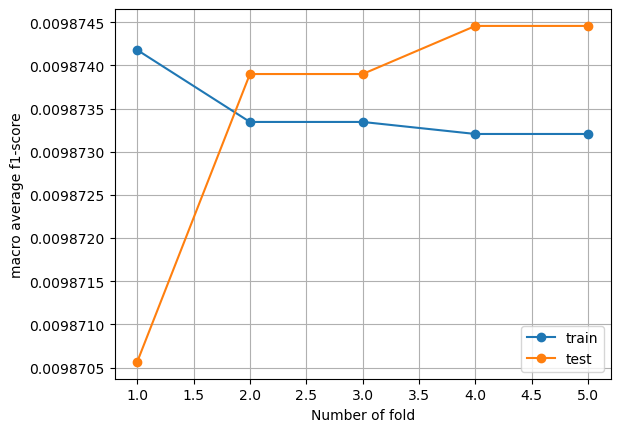

In [ ]:
best_model = baseline_mode_pipeline.steps[1][1]
performance_train, performance_test, kf = utils.check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_encoder=label_encoder,
    # random_state=SEED
)

print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, "o-", color="C0", label="train")
plt.plot(folds, performance_test, "o-", color="C1", label="test")
plt.legend()
plt.grid()
plt.xlabel("Number of fold")
plt.ylabel("macro average f1-score")
plt.show()

In [ ]:
# print classification report for holdout test data
print(classification_report(df_y_test["y_test"], df_y_test["preds_y_test"]))
# Store f1_macro
report = classification_report(df_y_test["y_test"], df_y_test["preds_y_test"], output_dict=True)
f1_score = report["accuracy"]
f1_macro = report["macro avg"]["f1-score"]

                            precision    recall  f1-score   support

   Blister and Insert Card       0.00      0.00      0.00      2475
  Blister and sealed blist       0.00      0.00      0.00      2155
            Book packaging       0.00      0.00      0.00         3
Cardb. Sleeve w - w/o Shr.       0.00      0.00      0.00       160
  Cardboard hanger w/o bag       0.00      0.00      0.00       115
    Carton cover (Lid box)       0.00      0.00      0.00       142
   Carton tube with or w/o       0.00      0.00      0.00         9
                      Case       0.00      0.00      0.00       140
         Corrugated carton       0.00      0.00      0.00      1009
        Countertop display       0.00      0.00      0.00        42
                  Envelope       0.00      0.00      0.00        88
          Fabric packaging       0.00      0.00      0.00         4
            Folding carton       0.00      0.00      0.00      2172
              Hanger/ Clip       0.17      1.00

### Track performance using MLflow

In [ ]:
# NOTE: Change to a meaningful name
EXPERIMENT_NAME = "AutoPackagingCategories"
RUN_NAME = "run_Naive_MostFrequent"

# with open('../env_vars.yml', 'r') as file:
#     env_vars = yaml.safe_load(file)

mlflow_dir = config["mlflow_benchmark_directory"]
os.makedirs(mlflow_dir, exist_ok=True)
mlflow.set_tracking_uri("file://" + mlflow_dir)

try:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    EXPERIMENT_ID = experiment.experiment_id
except AttributeError:
    EXPERIMENT_ID = mlflow.create_experiment(
        EXPERIMENT_NAME,
        # mlflow.set_artifact_uri("file://" + project_dir + "/artifacts/")
    )

current_time = datetime.datetime.now()
time_stamp = str(current_time)
# NOTE: Change to a meaningful name for the single trial
# exp_run_name = f"run_MeaningfulTrialName_{time_stamp}"
exp_run_name = f"{RUN_NAME}_{time_stamp}"

# Start MLflow
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=exp_run_name) as run:

    # Retrieve run id
    RUN_ID = run.info.run_id

    # Track parameters
    # track pipeline configs: preprocessing_pipeline
    mlflow.log_dict(baseline_mode_pipeline.named_steps, "preprocessing_pipeline.json")

    # mode specfic parameters
    mlflow.log_param("model", type(baseline_mode_pipeline.steps[1][1]))
    mlflow.log_param("model_configs", baseline_mode_pipeline.steps[1][1].get_params().items())

    # Track metrics
    mlflow.log_metric("Train_f1_macro", train_f1_macro)
    mlflow.log_metric("TestVal_f1_macro", test_f1_macro)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.log_metric("Report_Test_f1_score", f1_score)
    mlflow.log_metric("Report_Test_f1_macro", f1_macro)

    # Track model
    # mlflow.sklearn.log_model(clf, "classifier")